This notebook contains exploratory data plots. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data

import numpy as np
import pymc3 as pm
import pickle

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

Set Theano Environmental Variables for Parallelisation


In [3]:
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ("Albania","AL","ALB"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"), 
    ("Georgia","GE","GEO"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("Lithuania","LT","LTU"),
    ("Latvia","LV","LVA"),
    ("Malta","MT","MLT"),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Norway","NO","NOR"),
    ("New Zealand","NZ","NZL"),
    ("Poland","PL", "POL"),
    ("Portugal","PT","PRT"),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF"),
]

region_info.sort(key = lambda x: x[0])
region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])

In [31]:
data = preprocess_data('../merged_data/data_final_nov.csv', last_day='2020-05-30', smoothing=1, drop_features = ['Travel Screen/Quarantine', 'Travel Bans', 'Public Transport Limited',
                         'Internal Movement Limited', 'Public Information Campaigns', 'Symptomatic Testing'])
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [32]:
from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"/Users/mrinank/workspace/fonts/Font Awesome 5 Free-Solid-900.otf")


display_with = [
    [], [2, 3], 
    [3], [], [5], [], [], [], []
]

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)

cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]


In [33]:
for d, f in zip(display_with, data.CMs):
    for i in d:
        print(f"Display {f} with {data.CMs[i]}")

Display Gatherings <1000 with Gatherings <100
Display Gatherings <1000 with Gatherings <10
Display Gatherings <100 with Gatherings <10
Display Some Businesses Suspended with Most Businesses Suspended


In [34]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"

<ipython-input-35-6ff8526c354b>:205: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


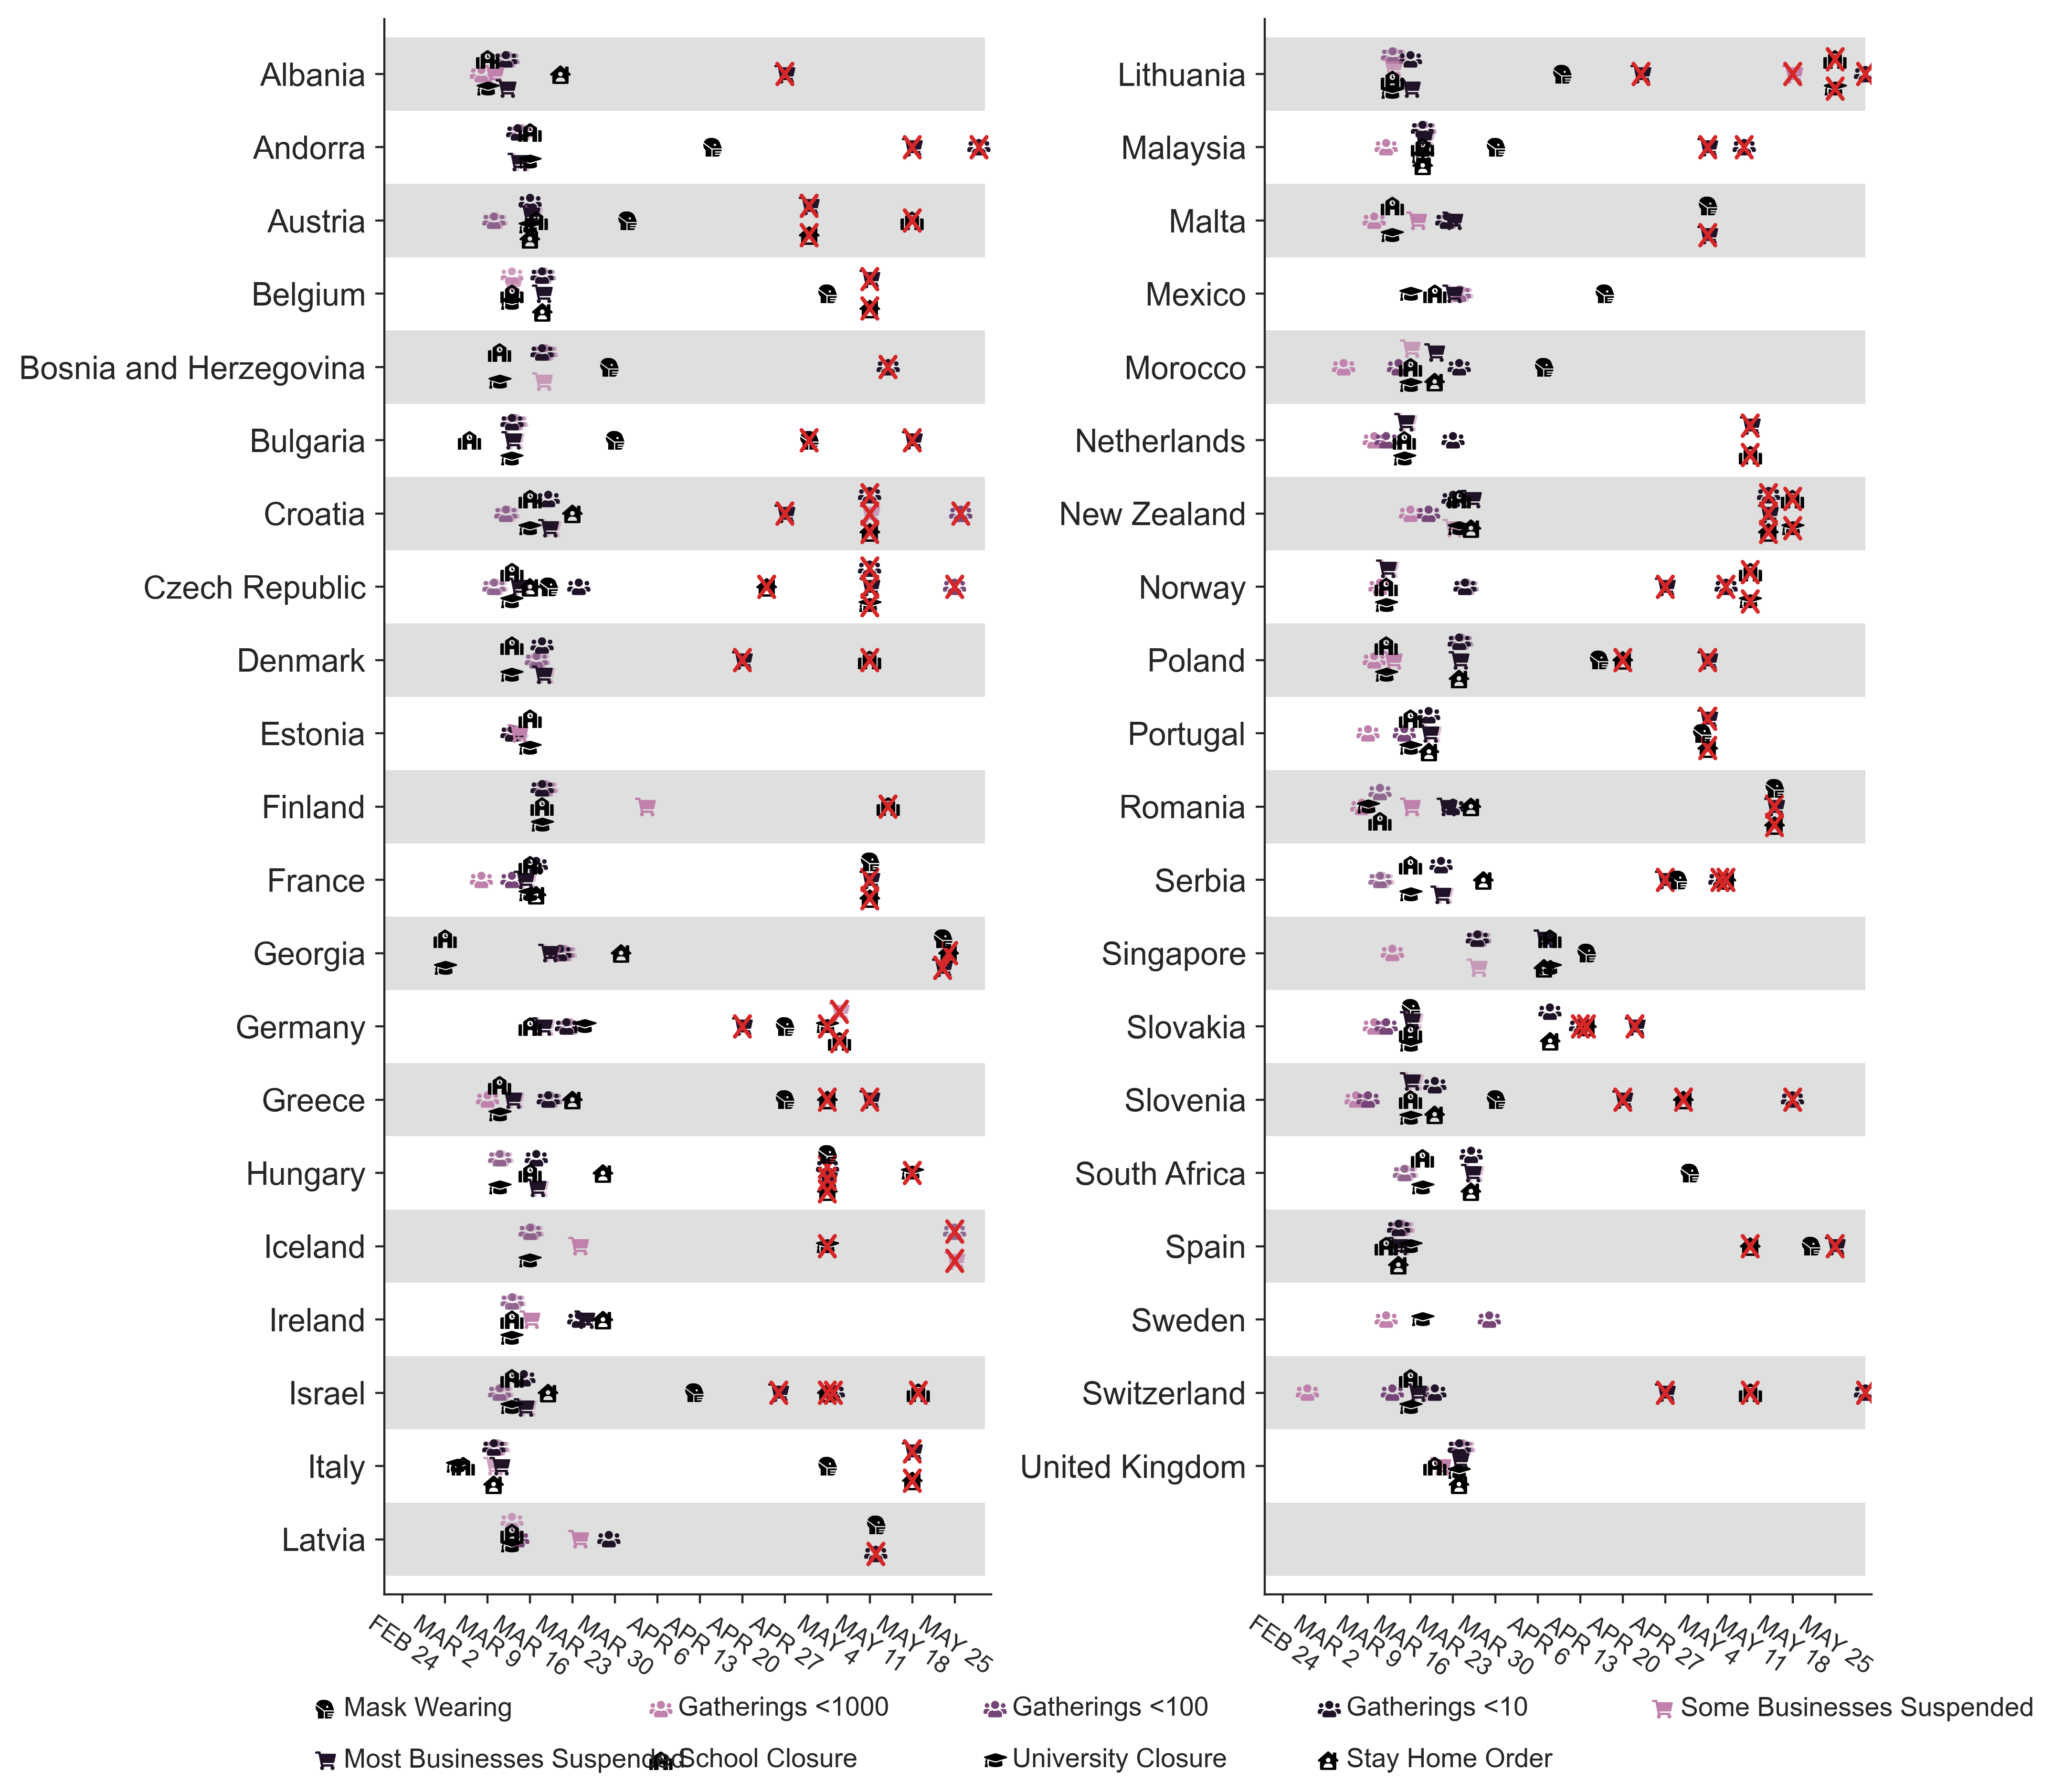

In [35]:
import matplotlib

dts = data.Ds
nDs = len(dts)
nRs = len(data.Rs)

x_min = 30
x_max = nDs

fig = plt.figure(figsize=(10, 9), dpi=400, constrained_layout=True)

spread_small = 0.4
spread_large = 0.5

nCMs = 9
plt.subplot(121)
for height in range(0, int(nRs/2)+1, 2):
    plt.fill_between(np.arange(x_min, nDs), -(height-0.5)* np.ones((nDs - x_min)), -(height+0.5)* np.ones((nDs - x_min)), color="silver", alpha=0.5, linewidth=0)

days_x = np.arange(len(dts))

for d_indx, region in enumerate(region_info[:21]):
    all_cm_values = data.ActiveCMs[d_indx, :, :]
    region_height = -d_indx
    
    a_cm_changes = np.zeros_like(all_cm_values)
    a_cm_changes[:, 1:] = (all_cm_values[:, 1:] - all_cm_values[:, :-1])
    
    all_cm_changes = np.zeros(all_cm_values[0, :].size)
    all_cm_changes[1:] = np.sum((all_cm_values[:, 1:] - all_cm_values[:, :-1])!= 0 , axis=0)
    all_cm_changes[0] = np.sum(all_cm_values[:, 0])
    cum_changes = np.zeros(all_cm_changes.size)
    
    for indx, f in enumerate(data.CMs):
        cm_values = all_cm_values[indx, :]
        cm_changes = np.zeros(cm_values.size)
        cm_changes[1:] = cm_values[1:] - cm_values[:-1]
        cm_changes[0] = 1 if cm_values[0] == 1 else 0
        
        nz = (np.nonzero(cm_changes)[0]).tolist()
        
        for nz_val in nz:
            all_changes = all_cm_changes[nz_val]
            delta_x = 0
            alpha = 1
            height = region_height
                        
            if all_changes > 1:
                effective_changes = 0
                for cm in range(nCMs):
                    if a_cm_changes[cm, nz_val] != 0:
                        if len(display_with[cm]) > 0:
                            for other_display in display_with[cm]:
                                if a_cm_changes[other_display, nz_val] == 1.0:
                                    break
                                else:
                                    effective_changes += 1
                        else:
                            effective_changes += 1

                if effective_changes > 2:
                    spread = spread_large
                else:
                    spread = spread_small
                
                if effective_changes > 1:
                    height = (region_height + spread/2) - ((spread/(effective_changes-1)) * cum_changes[nz_val])
                else:
                    height = region_height
                
                if len(display_with[indx]) > 0:
                    for other_display in display_with[indx]:
                        if a_cm_changes[other_display, nz_val] != 0:
                            delta_x += 0.4
                            alpha = 0.5
                    
                    if a_cm_changes[display_with[indx][0], nz_val] == 0:
                        cum_changes[nz_val] += 1
                        alpha = 0.75
                else:
                    # if display with is empty
                    cum_changes[nz_val] += 1
                
            if cm_changes[nz_val] == 1.0:
                plt.text(nz_val + delta_x, height, cm_plot_style[indx][0], fontproperties=fp2, color=cm_plot_style[indx][1], size=7, alpha=alpha, va="center", ha="center", clip_on=True)
            
            elif cm_changes[nz_val] == -1:
                plt.text(nz_val + delta_x, height, cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=7, alpha=alpha, va="center", ha="center", clip_on=True, zorder=1)
                plt.plot([nz_val-1.25, nz_val+1.25], [height+0.14, height-0.14], color="tab:red", zorder=2, linewidth=1.5)
                plt.plot([nz_val+1.25, nz_val-1.25], [height+0.14, height-0.14], color="tab:red", zorder=2, linewidth=1.5)
                
            else:
                print(f"Something weird Region {region[0]} NPI: {f} {cm_changes[nz_val-1]}")
        
locs = np.arange(5, nDs, 7)
xlabels = [f"{month_to_str(dts[ts].month)} {dts[ts].day}" for ts in locs]

plt.xticks(locs, xlabels, rotation=-35, fontsize=9)
plt.xlim([x_min, x_max])
plt.yticks(-np.arange(len(region_names)), region_names, fontsize=12)
plt.ylim([-20.75, 0.75])

plt.subplot(122)
for height in range(0, int(nRs/2)+1, 2):
    plt.fill_between(np.arange(x_min, nDs), -(height-0.5)* np.ones((nDs - x_min)), -(height+0.5)* np.ones((nDs - x_min)), color="silver", alpha=0.5, linewidth=0)

days_x = np.arange(len(dts))

for d_indx, region in enumerate(region_info[21:]):
    all_cm_values = data.ActiveCMs[21 + d_indx, :, :]
    region_height = -d_indx
    
    a_cm_changes = np.zeros_like(all_cm_values)
    a_cm_changes[:, 1:] = (all_cm_values[:, 1:] - all_cm_values[:, :-1])
    
    all_cm_changes = np.zeros(all_cm_values[0, :].size)
    all_cm_changes[1:] = np.sum((all_cm_values[:, 1:] - all_cm_values[:, :-1])!= 0 , axis=0)
    all_cm_changes[0] = np.sum(all_cm_values[:, 0])
    cum_changes = np.zeros(all_cm_changes.size)
    
    for indx, f in enumerate(data.CMs):
        cm_values = all_cm_values[indx, :]
        cm_changes = np.zeros(cm_values.size)
        cm_changes[1:] = cm_values[1:] - cm_values[:-1]
        cm_changes[0] = 1 if cm_values[0] == 1 else 0
        
        nz = (np.nonzero(cm_changes)[0]).tolist()
        
        for nz_val in nz:
            all_changes = all_cm_changes[nz_val]
            delta_x = 0
            alpha = 1
            height = region_height
                        
            if all_changes > 1:
                effective_changes = 0
                for cm in range(nCMs):
                    if a_cm_changes[cm, nz_val] != 0:
                        if len(display_with[cm]) > 0:
                            for other_display in display_with[cm]:
                                if a_cm_changes[other_display, nz_val] == 1.0:
                                    break
                                else:
                                    effective_changes += 1
                        else:
                            effective_changes += 1

                if effective_changes > 2:
                    spread = spread_large
                else:
                    spread = spread_small
                
                if effective_changes > 1:
                    height = (region_height + spread/2) - ((spread/(effective_changes-1)) * cum_changes[nz_val])
                else:
                    height = region_height
                
                if len(display_with[indx]) > 0:
                    for other_display in display_with[indx]:
                        if a_cm_changes[other_display, nz_val] != 0:
                            delta_x += 0.4
                            alpha = 0.5
                    
                    if a_cm_changes[display_with[indx][0], nz_val] == 0:
                        cum_changes[nz_val] += 1
                        alpha = 0.75
                else:
                    # if display with is empty
                    cum_changes[nz_val] += 1
                
            if cm_changes[nz_val] == 1.0:
                plt.text(nz_val + delta_x, height, cm_plot_style[indx][0], fontproperties=fp2, color=cm_plot_style[indx][1], size=7, alpha=alpha, va="center", ha="center", clip_on=True)
            
            elif cm_changes[nz_val] == -1:
                plt.text(nz_val + delta_x, height, cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=7, alpha=alpha, va="center", ha="center", clip_on=True, zorder=1)
                plt.plot([nz_val-1.25, nz_val+1.25], [height+0.14, height-0.14], color="tab:red", zorder=2, linewidth=1.5)
                plt.plot([nz_val+1.25, nz_val-1.25], [height+0.14, height-0.14], color="tab:red", zorder=2, linewidth=1.5)
            
            else:
                print(f"Something weird Region {region[0]} NPI: {f} {cm_changes[nz_val-1]}")
        
locs = np.arange(5, nDs, 7)
xlabels = [f"{month_to_str(dts[ts].month)} {dts[ts].day}" for ts in locs]

# plt.plot([x_min, x_max], [-18.5, -18.5], color="k", zorder=-3)
# plt.text(x_min + 1, -(data.Rs.index("SG")-22), cm_plot_style[0][0], fontproperties=fp2,  color=cm_plot_style[1][1], size=7, va="center", ha="center", clip_on=True, zorder=1)

# import matplotlib.patches as patches

for indx, f in enumerate(data.CMs):
    fig.text(-0.015 + 0.185 + 0.175 * (indx%5), -0.03 * np.floor((indx/5)) , cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=7, va="center", ha="left", clip_on=True, zorder=1)
    fig.text(-0.015 + 0.2 + 0.175 * (indx%5), -0.00003 + -0.03 * np.floor((indx/5)), f, size=10, va="center", ha="left")

x,y = np.array([[0.05, 0.1, 0.9], [0.05, 0.5, 0.9]])
line = matplotlib.lines.Line2D(x, y, lw=5., color='r', alpha=0.4)
plt.gca().add_line(line)

plt.xticks(locs, xlabels, rotation=-35, fontsize=9)
plt.xlim([x_min, x_max])
plt.yticks(-np.arange(len(region_names[21:])), region_names[21:], fontsize=12)
plt.ylim([-20.75, 0.75])

# plt.suptitle("NPI Implementation Timeline")
sns.despine()
plt.tight_layout()
plt.savefig("time.svg", bbox_inches = "tight")

In [ ]:
data.Ds[30]

In [ ]:
f;

In [ ]:
colors = sns.color_palette('colorblind')

In [ ]:
for r, rg in enumerate(data.Rs):
    plt.figure(figsize=(5, 3), dpi=300)
    plt.title(data.RNames[rg][0])
    for cm in range(9):
        plt.plot(data.ActiveCMs[r, cm, :], color=colors[cm], label=data.CMs[cm])
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    plt.xlim([40, 120])